# Introduction

* **Why We Should Care About Payment Fraud?**

Payment card fraud is a serious and long-term threat to society  with an economic impact forecast to be $416bn in 2017.

Besides financial losses, it has been identified that criminal enterprises and Organised
Crime Groups (OCGs) use payment card fraud to fund their activities
including arms, drugs and terrorism. The activities of these criminals include violence and murder--individual acts of fraud have a human cost.

Fraud is increasing dramatically with the progression of modern technology and global communication. As a result, fighting
fraud has become an important issue to be explored. As presented in the following figure, the detection and 
prevention mechanisms are used mostly to combat fraud.

![Protection systems against fraud](./images/Protection_systems_against_fraud.png)

* **What is Fraud Detection ?**

Fraud detection tries to discover and
identify fraudulent activities as they enter the systems and report
them to a system administrator

* **Payment card transaction process**

There are multiple participants that are involved when a cashless
transaction takes place(see the picture below).

![Issues](./images/payment.png)

* **Fraud detection issues and challenges**

The following figure shows distribution of FDS articles
based on issues and challenges

![Issues](./images/issues.png)

1. Concept Drift

The detection of fraud is nonstationary as fraud vectors change over
time and thus when a fixed FMS is put in place the effectiveness is reduced over time.

2. Unbalanced Data

There is a large class imbalance, so that the Ratio of Genuine to
Fraud (RGF) transactions in real-world transactional datasets
is high; there are considerably fewer fraud transactions compared to
genuine transactions making the problem of classifying them nontrivial. In industry, human
reviewers tend to mistrust and can ignore alerts and information from
the FMS if it generates too many false alarms

I have written a blog about how to deal with imbalanced data [here.](https://medium.com/@haataa/fighting-imbalance-data-set-with-code-examples-f2a3880700a6)

3. Real Time Detection

The loss due to fraud is incurred at the moment of the transaction
for issuers and merchants. Therefore, to be effective, fraud needs to be
detected in real-time. A real-time FMS is illustrated in the figure below.
![Issues](./images/realtime.png)

* **Credit card fraud detection**

Mostly, the strategy of credit card fraud detection is pattern recognition by analyzing user spending behavior automatically.
Customer spending behavior contains information about **the
transaction amount, time gap since last purchase, day of the week,
item category, customer address, etc.** Anomaly based fraud detection is mostly used for credit card fraud detection system in
which the cardholder's profile is made up by analyzing the cardholder spending behavior pattern. In doing so, any incoming
transaction that is inconsistent with the cardholder's profile would
be considered as suspicious

* **references**

[Fraud detection system: A survey](https://son.ir/wp-content/uploads/2018/10/02cfc86711083c79d23674505833131e2.pdf)

[How Artificial Intelligence and machine learning research impacts payment card fraud detection: A survey and industry benchmark](https://www.sciencedirect.com/science/article/abs/pii/S0952197618301520#fn1)

[Fraud The Facts 2014](http://www.theukcardsassociation.org.uk/wm_documents/Fraud%20The%20Facts%202014.pdf)

# Load Data

In [288]:
import gc
import os
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Check File Size 

In [2]:
def check_fsize(dpath,s=30):
    """check file size
    Args:
    dpath: file directory
    s: string length in total after padding
    
    Returns:
    None
    """
    for f in os.listdir(dpath):
        print(f.ljust(s) + str(round(os.path.getsize(dpath+'/' + f) / 1000000, 2)) + 'MB')

In [16]:
check_fsize('./data')

sample_submission.csv.zip     1.19MB
test_identity.csv.zip         3.11MB
test_transaction.csv          613.19MB
train_transaction.csv         683.35MB
train_transaction.csv.zip     55.06MB
train_identity.csv.zip        3.17MB
test_identity.csv             25.8MB
train_identity.csv            26.53MB
test_transaction.csv.zip      49.63MB


In [6]:
def check_fline(fpath):
    """check total number of lines of file for large files
    
    Args:
    fpath: string. file path
    
    Returns:
    None
    
    """
    lines = subprocess.run(['wc', '-l', fpath], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

In [18]:
fs=['./data/train_transaction.csv', './data/train_identity.csv', './data/test_transaction.csv','./data/test_identity.csv']
[check_fline(s) for s in fs]

590541 ./data/train_transaction.csv
144234 ./data/train_identity.csv
506692 ./data/test_transaction.csv
141908 ./data/test_identity.csv


[None, None, None, None]

# Load Data

In [28]:
# Load sample training data
df_train_transac = pd.read_csv('./data/train_transaction.csv')
df_train_identity = pd.read_csv('./data/train_identity.csv')

(590540, 394)
(144233, 41)


In [48]:
# Show data shape
print(df_train_transac.shape)
print(df_train_identity.shape)

# Show data head
print(df_train_transac.head(2))
print(df_train_identity.head(2))

(590540, 394)
(144233, 41)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   

   card2  card3       card4  card5  ...  V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...   NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...   NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  

[2 rows x 394 columns]
   TransactionID  id_01    id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0  70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0  98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   

   id_09              ...                              id_31  id_32  \
0    NaN              ...                samsung browser 6.2   32.0   
1    NaN              ..

## Check Feature Type

In [21]:
def count_feature_type(df):
    return df.dtypes.value_counts()

In [31]:
print(count_feature_type(df_train_transac))
print(count_feature_type(df_train_identity)

float64    376
object      14
int64        4
dtype: int64
float64    23
object     17
int64       1
dtype: int64


# Explore Transaction Data
First take a closer look on transaction data. Start with the general data missing condition.

## Check Target Distribution

In [55]:
def check_cunique(df,cols):
    """check unique values for each column
    df: data frame. 
    cols: list. The columns of data frame to be counted
    """
    df_nunique = df[cols].nunique().to_frame()
    df_nunique = df_nunique.reset_index().rename(columns={'index': 'feat',0:'nunique'})
    return df_nunique

In [56]:
def feat_value_count(df,colname):
    """value count of each feature
    
    Args
    df: data frame.
    colname: string. Name of to be valued column
    
    Returns
    df_count: data frame.
    """
    df_count = df[colname].value_counts().to_frame().reset_index()
    df_count = df_count.rename(columns={'index':colname+'_values',colname:'counts'})
    return df_count

In [57]:
feat_value_count(df_train_transac,'isFraud')

,isFraud_values,counts
0,0,569877
1,1,20663


Obviously this is a imbalanced classification problem. Only 3.5% of data is of target 1.

## Check Missing Value 

In [42]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [43]:
df_colmissing = check_missing(df_train_transac,cols=None,axis=0)
df_colmissing.head()

,missing_num,missing_percent
dist2,552913,93.628374
D7,551623,93.409930
D13,528588,89.509263
D14,528353,89.469469
D12,525823,89.041047


Some colunms have very high missing rate.

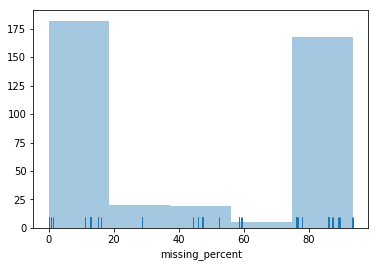

In [44]:
sns.distplot(df_colmissing.missing_percent, kde=False, rug=True)

In [46]:
df_rowmissing = check_missing(df_train_transac,cols=None,axis=1)
df_rowmissing.head()

,missing_num,missing_percent
522237,300,76.142132
522280,296,75.126904
474068,292,74.111675
31095,292,74.111675
474362,292,74.111675


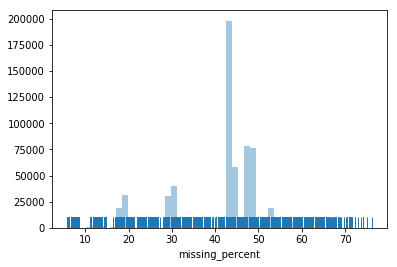

In [47]:
sns.distplot(df_rowmissing.missing_percent, kde=False, rug=True)

## Check feature unique value

In [65]:
df_nunique = check_cunique(df_train_transac,df_train_transac.select_dtypes(include=['object']).columns)
df_nunique

,feat,nunique
0,ProductCD,5
1,card4,4
2,card6,4
3,P_emaildomain,59
4,R_emaildomain,60
5,M1,2
6,M2,2
7,M3,2
8,M4,3
9,M5,2


### Check ProductCD

In [213]:
def compare_cate(df,colname,targetname):
    """check target value difference of given category
    in the case of binary classifications.
    
    Args
    df: data frame.
    colname: string. The column name to be evaluated.
    targetname: string. The column name of the target variable.
    
    Returns
    None
    """
    # caculate aggregate stats
    df_cate = df.groupby([colname])[targetname].agg(['count', 'sum','mean'])
    df_cate.reset_index(inplace=True)
    print(df_cate)
    
    # plot visuals
    f, ax = plt.subplots(figsize=(15, 6))
    plt1 = sns.lineplot(x=colname, y="mean", data=df_cate,color="r")

    for tl in ax.get_yticklabels():
        tl.set_color('r')

    ax2 = ax.twinx()
    plt2 = sns.barplot(x=colname, y="count", data=df_cate,
                       ax=ax2,alpha=0.5)
    

  ProductCD   count   sum      mean
0         C   68519  8008  0.116873
1         H   33024  1574  0.047662
2         R   37699  1426  0.037826
3         S   11628   686  0.058996
4         W  439670  8969  0.020399


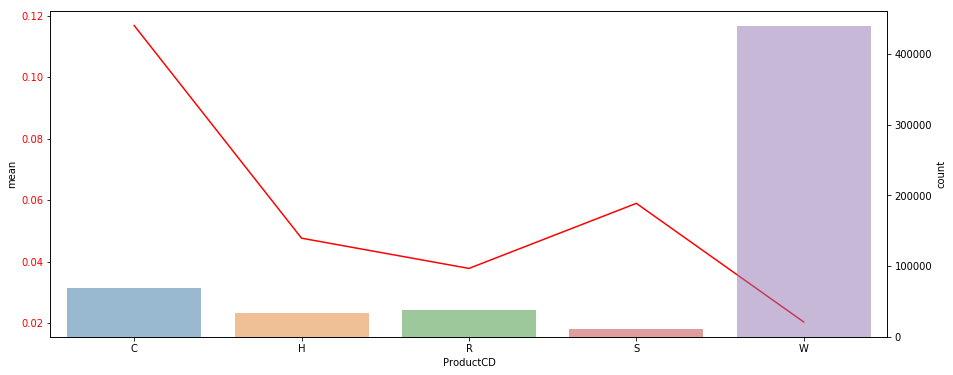

In [214]:
compare_cate(df_train_transac,'ProductCD','isFraud')

ProductCD: product code, the product for each transaction

Five category of products. And type 'W' is the marjority. 

However type 'C' has highest fault rate.

### Check card4

              card4   count    sum      mean
0  american express    8328    239  0.028698
1          discover    6651    514  0.077282
2        mastercard  189217   6496  0.034331
3              visa  384767  13373  0.034756


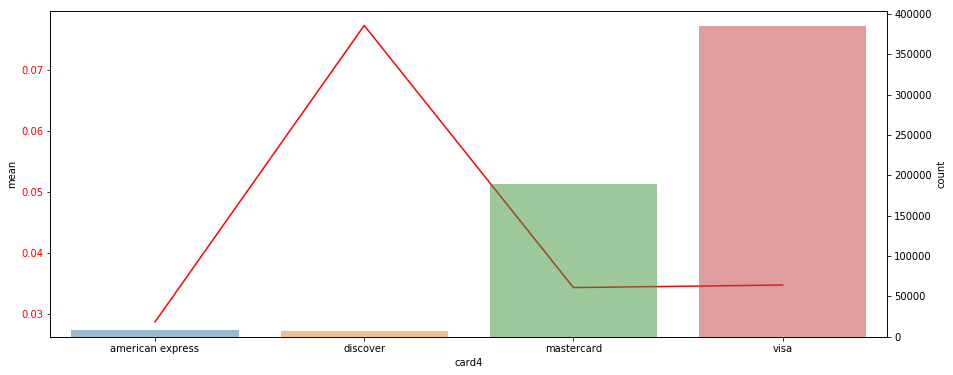

In [212]:
compare_cate(df_train_transac,'card4','isFraud')

OK, card4 means card issue bank. I have to say that I never head discover card before. 

Discover card fraud rate is higher compared to other three.

### Check card6

             card6   count    sum      mean
0      charge card      15      0  0.000000
1           credit  148986   9950  0.066785
2            debit  439938  10674  0.024263
3  debit or credit      30      0  0.000000


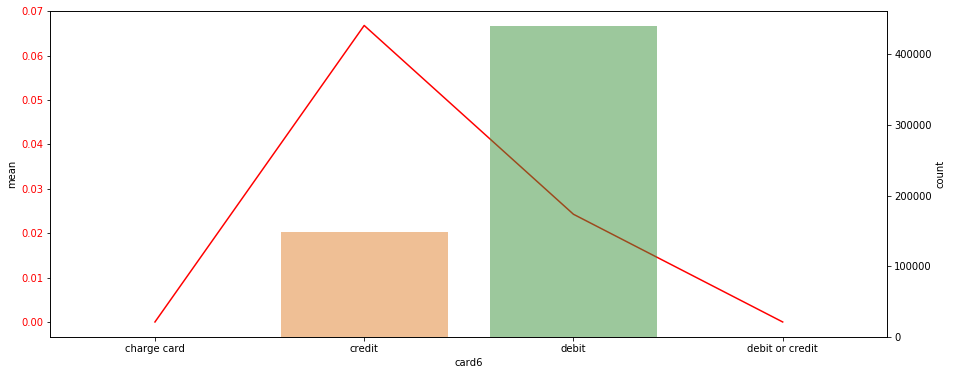

In [215]:
compare_cate(df_train_transac,'card6','isFraud')

So card6 means card type. Now some information.

**Credit cards** allow you to purchase items up to your credit limit. You can repay them within the month to avoid interest charges (if there is a grace period), or you can make smaller payments over a longer period of time which will result in interest charges.

**Charge cards** are similar to credit cards in that they allow you to pay for purchases up to your credit limit. Some charge cards do not have a predetermined credit limit and will approve larger purchases on a case-by-case basis. Charge cards require the balance to be paid back in a short period of time, usually within a month.

**Debit cards** are tied to a bank account from which funds are withdrawn for each purchase. Therefore, you will get a debit card from your financial institution where you have a personal or business checking or savings account.

### Check card1~5

In [228]:
check_cunique(df_train_transac,['card1','card2','card3','card5'])

,feat,nunique
0,card1,13553
1,card2,500
2,card3,114
3,card5,119


According to the competition host, card1~card6 are all categorical features. It's a bit add there are so many unique values of these features.

### Check P_emaildomain

In [216]:
feat_value_count(df_train_transac,'P_emaildomain').head()

,P_emaildomain_values,counts
0,gmail.com,228355
1,yahoo.com,100934
2,hotmail.com,45250
3,anonymous.com,36998
4,aol.com,28289


purchaser and recipient email domain. Interesting, I think perhaps the final domain like .com/.jp will provide additional information

### Check R_emaildomain

In [217]:
feat_value_count(df_train_transac,'R_emaildomain').head()

,R_emaildomain_values,counts
0,gmail.com,57147
1,hotmail.com,27509
2,anonymous.com,20529
3,yahoo.com,11842
4,aol.com,3701


I have to say that some email address looks pretty strange.

### Check M1

  M1   count   sum      mean
0  F      25     0  0.000000
1  T  319415  6342  0.019855


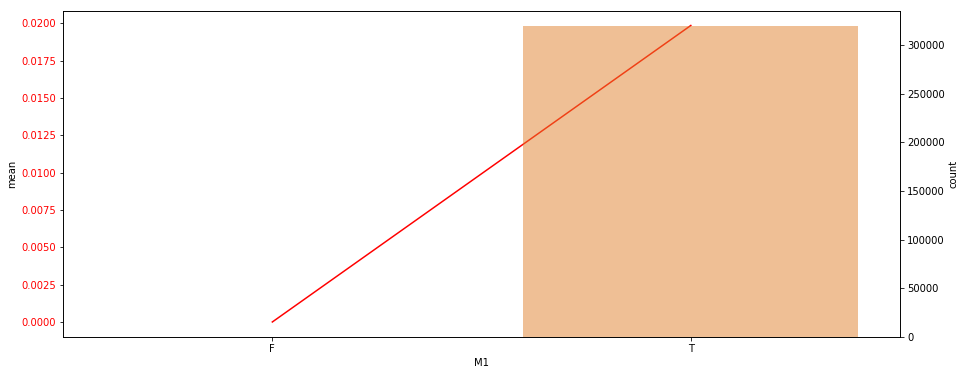

In [218]:
compare_cate(df_train_transac,'M1','isFraud')

M1-M9：match, such as names on card and address. I think this is quite straight forward. False would lead to high prob of fraud. However in the case of M1,M5,M7, 'F' result in less fraud rate. And I have no idea why M4 is different from the others.

### Check addr1

In [219]:
feat_value_count(df_train_transac,'addr1').head()

,addr1_values,counts
0,299.0,46335
1,325.0,42751
2,204.0,42020
3,264.0,39870
4,330.0,26287


Notice that feature addr1 is also categroical feature. Addr1 has 332 unique values.

### Check addr2

In [220]:
feat_value_count(df_train_transac,'addr2').head()

,addr2_values,counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


    addr2   count    sum      mean
0    10.0       8      8  1.000000
1    13.0       7      0  0.000000
2    14.0       1      0  0.000000
3    15.0       1      0  0.000000
4    16.0      55      0  0.000000
5    17.0       7      0  0.000000
6    18.0       3      0  0.000000
7    19.0      33      0  0.000000
8    20.0       3      0  0.000000
9    21.0       5      0  0.000000
10   22.0       1      0  0.000000
11   23.0       2      0  0.000000
12   24.0       3      0  0.000000
13   25.0       1      0  0.000000
14   26.0      25      0  0.000000
15   27.0      20      0  0.000000
16   28.0       4      0  0.000000
17   29.0      11      1  0.090909
18   30.0       4      0  0.000000
19   31.0      47      0  0.000000
20   32.0      91      6  0.065934
21   34.0      16      0  0.000000
22   35.0       1      0  0.000000
23   36.0       2      1  0.500000
24   38.0       3      2  0.666667
25   39.0       3      0  0.000000
26   40.0       3      0  0.000000
27   43.0      12   

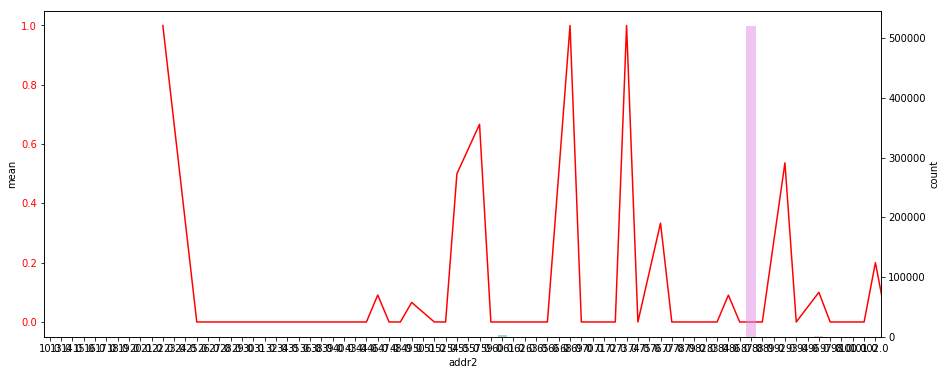

In [233]:
compare_cate(df_train_transac,'addr2','isFraud')

Compare to addr1 has more than 300 unique values, addr2 has only 74. Perhaps this indicates nation code and addr1 province? Also notice that 87 has far more counts. More interesting is that some place has 100% fraud rate.

### Check TransactionAmt

In [100]:
def check_distribution(df,colname):
    """check general feature distribution info and plot histogram
    
    Args
    df: data frame.
    colname: string. The column name to be evaluated.
    
    Returns
    None
    """
    print(df[colname].describe())
    print('Total missing value number: ',df[colname].isnull().sum())
    plt.figure(figsize=(12,5))
    sns.distplot(df[colname].dropna())

In [141]:
def compare_distribution(df,colname,targetname,targetdict):
    """check column distribution difference of give different target variable
    in the case of binary classifications.
    
    Args
    df: data frame.
    colname: string. The column name to be evaluated.
    targetname: string. The column name of the target variable.
    targetdict:dict. Vaule and name of each class.
    
    Returns
    None
    """
    plt.figure(figsize=(12,5))
    keys = list(targetdict.keys())
    plt1 = sns.distplot(df[df[targetname] == keys[0]][colname].dropna(), label=targetdict[keys[0]])
    plt1 = sns.distplot(df[df[targetname] == keys[1]][colname].dropna(), label=targetdict[keys[1]])
    plt1.legend()
    plt1.set_title("%s Distribution by Target"%colname, fontsize=20)
    plt1.set_xlabel(colname, fontsize=18)
    plt1.set_ylabel("Probability", fontsize=18)

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64
Total missing value number:  0


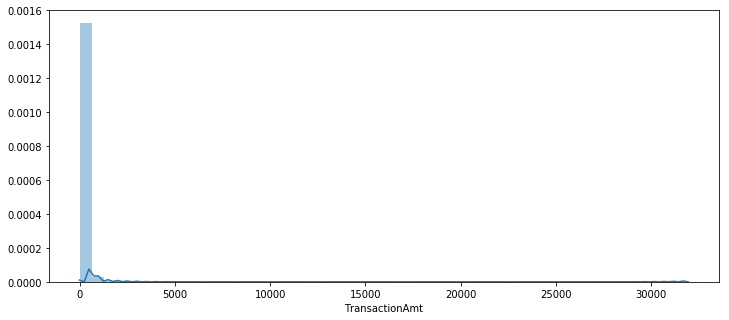

In [101]:
check_distribution(df_train_transac,'TransactionAmt')

So most transactions are less than 125.

In [102]:
df_train_transac.groupby(['isFraud'])['TransactionAmt'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,569877.0,134.511665,239.395078,0.251,43.970,68.5,120.0,31937.391
1,20663.0,149.244779,232.212163,0.292,35.044,75.0,161.0,5191.000


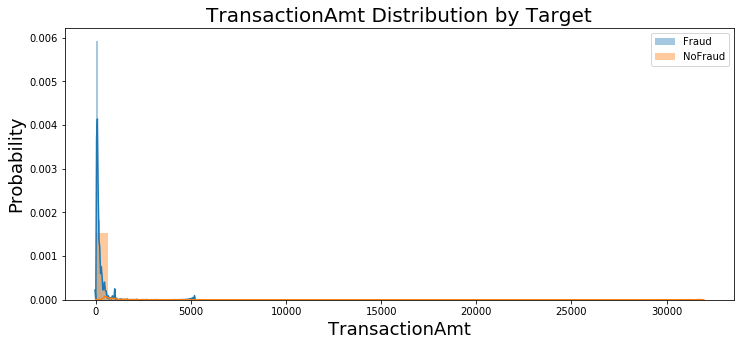

In [145]:
dict= {1:'Fraud',0:'NoFraud'}
compare_distribution(df_train_transac,'TransactionAmt','isFraud',dict)

### Check Dist

count    238269.000000
mean        118.502180
std         371.872026
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64
Total missing value number:  352271


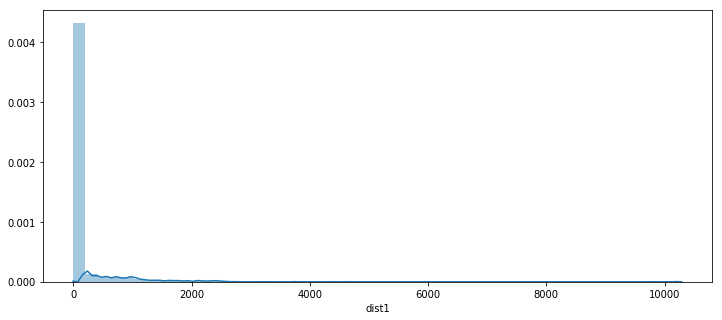

In [103]:
check_distribution(df_train_transac,'dist1')

In [104]:
df_train_transac.groupby(['isFraud'])['dist1'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,233514.0,117.360098,370.641879,0.0,3.0,8.0,24.0,10286.0
1,4755.0,174.588854,424.232313,0.0,3.0,10.0,85.5,4942.0


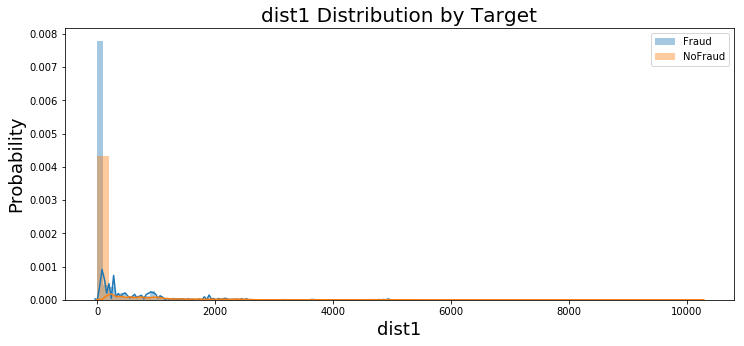

In [143]:
compare_distribution(df_train_transac,'dist1','isFraud',dict)

count    37627.000000
mean       231.855423
std        529.053494
min          0.000000
25%          7.000000
50%         37.000000
75%        206.000000
max      11623.000000
Name: dist2, dtype: float64
Total missing value number:  552913


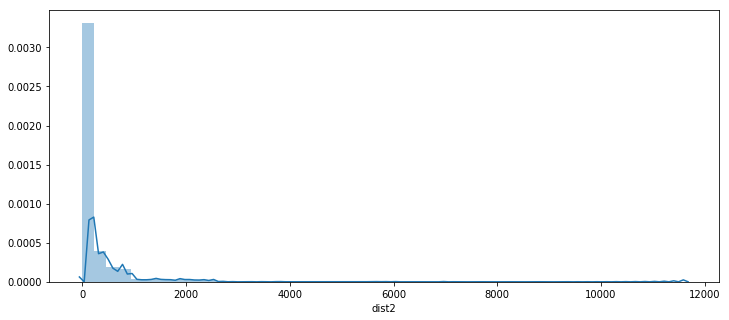

In [105]:
check_distribution(df_train_transac,'dist2')

In [106]:
df_train_transac.groupby(['isFraud'])['dist2'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,33896.0,235.199758,536.798492,0.0,7.0,36.0,206.0,11623.0
1,3731.0,201.472259,451.589576,0.0,7.0,49.0,233.0,9337.0


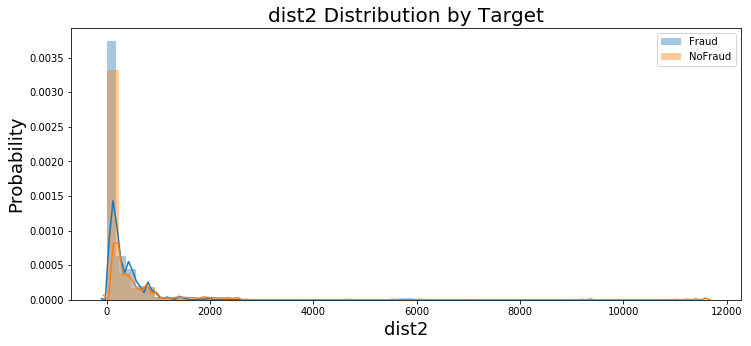

In [144]:
compare_distribution(df_train_transac,'dist2','isFraud',dict)

### Check C1~C14

            count       mean         std  min  25%  50%  75%     max
isFraud                                                             
0        569877.0  13.314952  127.787969  0.0  1.0  1.0  3.0  4685.0
1         20663.0  35.535740  242.976260  0.0  1.0  2.0  6.0  4682.0
            count       mean         std  min  25%  50%  75%     max
isFraud                                                             
0        569877.0  14.173283  147.485925  0.0  1.0  1.0  3.0  5691.0
1         20663.0  45.509413  287.813648  0.0  1.0  2.0  7.0  5690.0
            count      mean       std  min  25%  50%  75%   max
isFraud                                                        
0        569877.0  0.005840  0.153208  0.0  0.0  0.0  0.0  26.0
1         20663.0  0.000242  0.015554  0.0  0.0  0.0  0.0   1.0
            count       mean         std  min  25%  50%  75%     max
isFraud                                                             
0        569877.0   3.693878   65.839255  0.0  0.0  0.

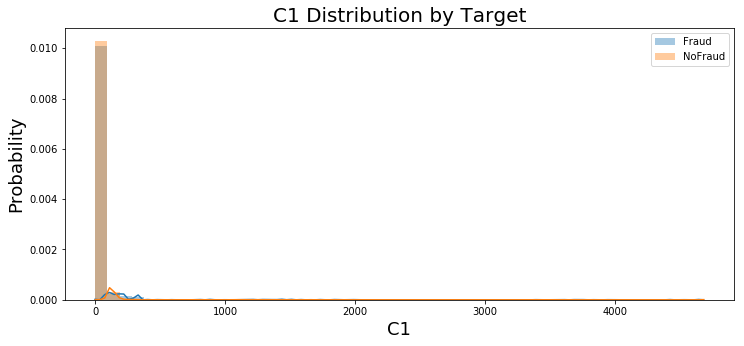

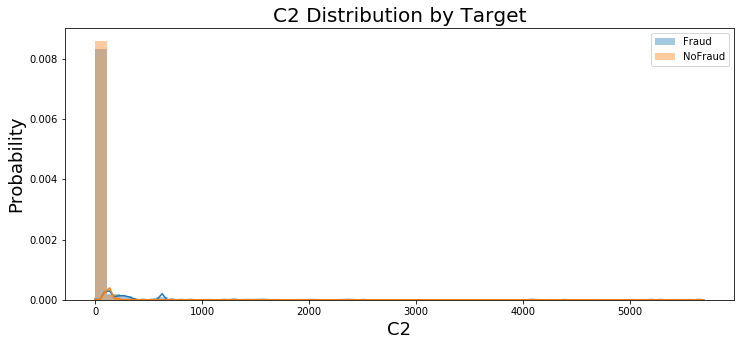

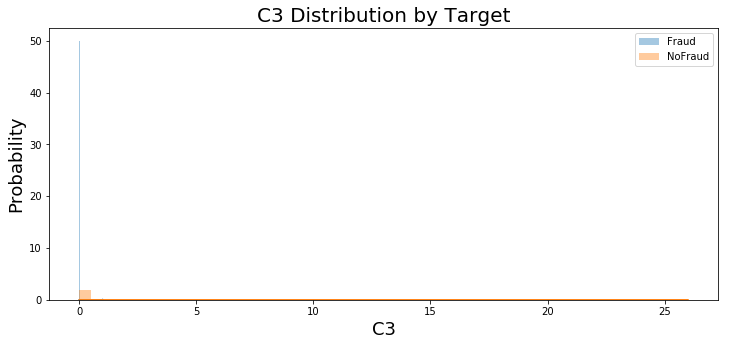

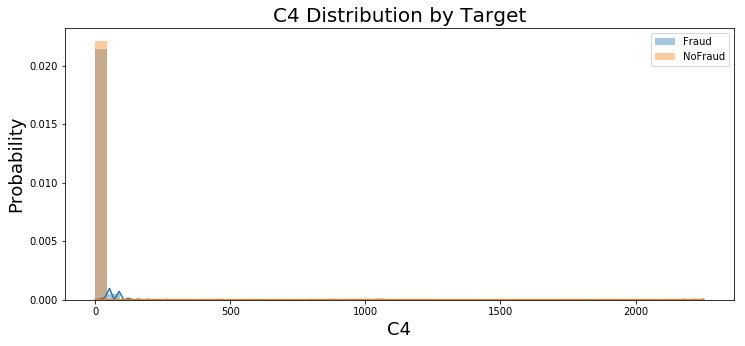

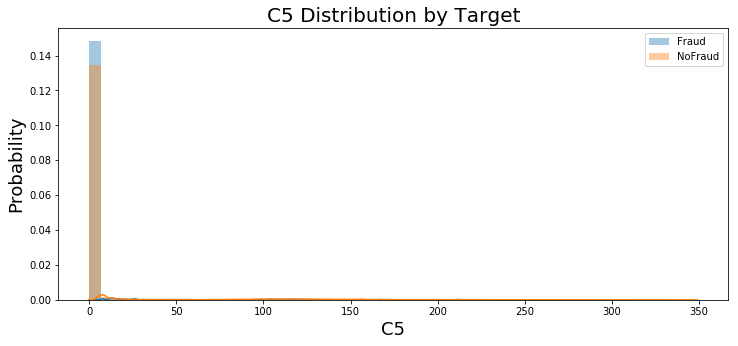

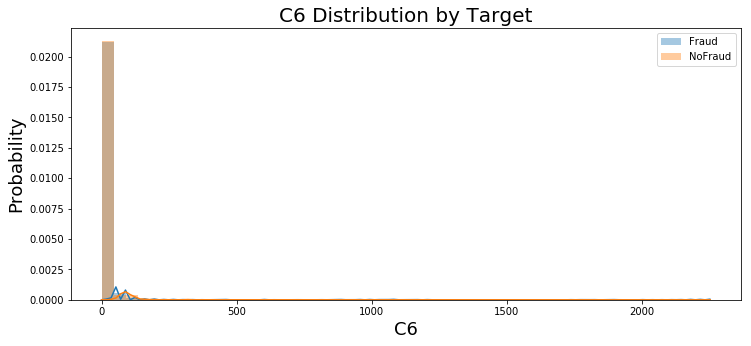

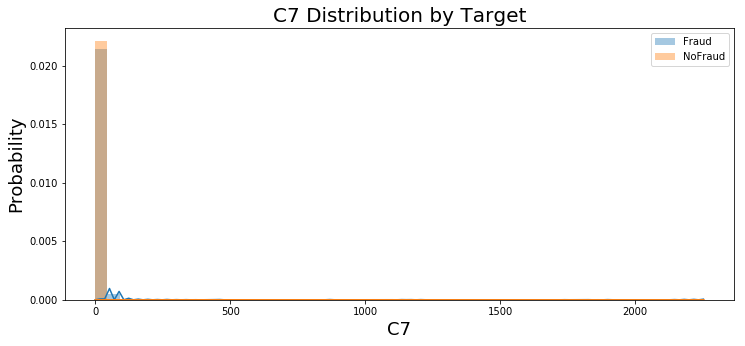

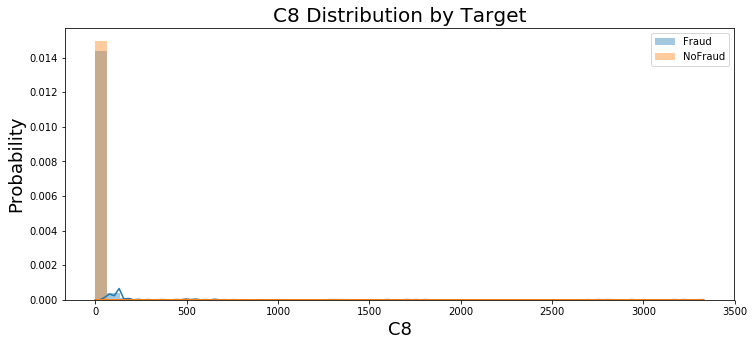

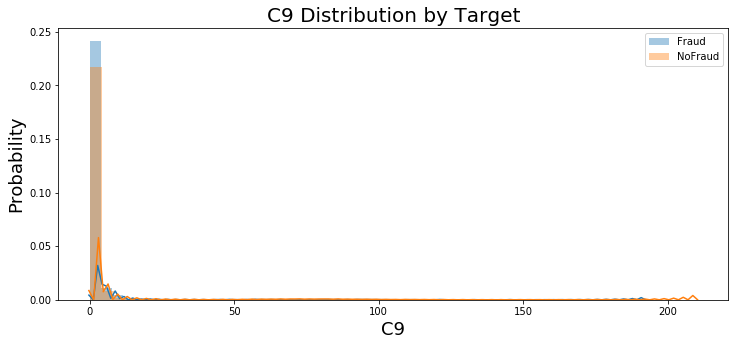

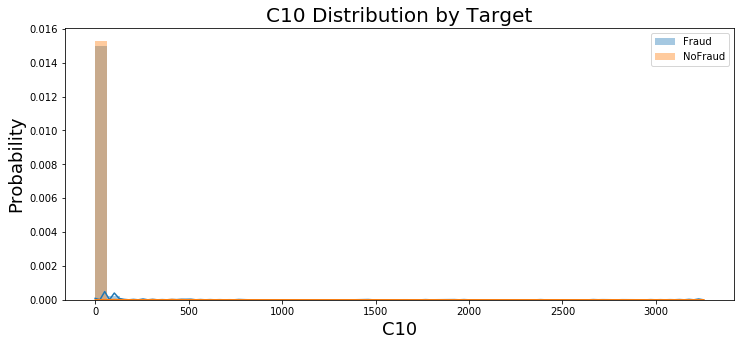

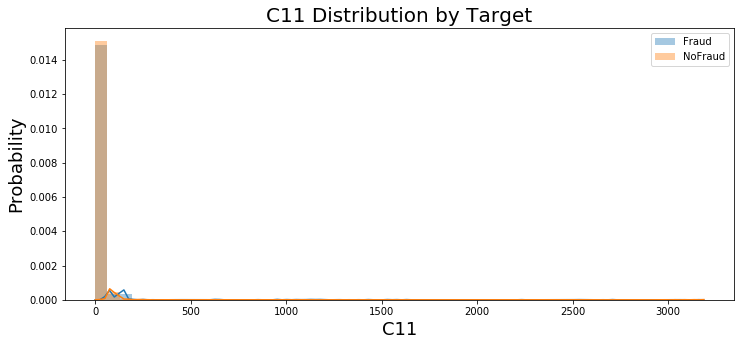

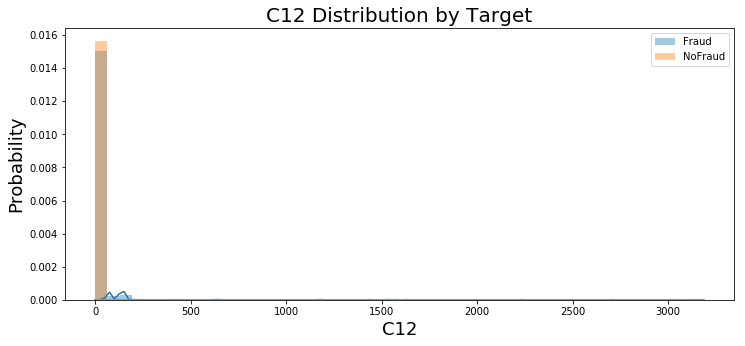

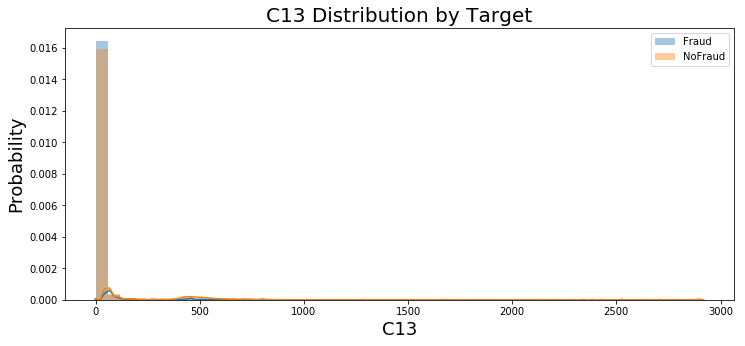

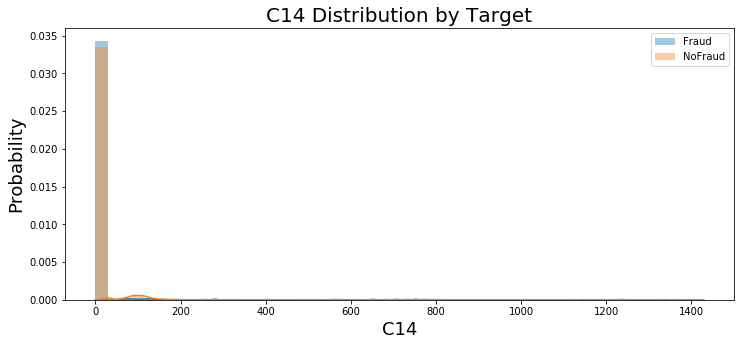

In [253]:
for i in range(0,14):
    col = 'C%s'%(i+1)
    print(df_train_transac.groupby(['isFraud'])[col].agg('describe'))
    compare_distribution(df_train_transac,col,'isFraud',dict)

It looks like we have outlier values

### Check D1~D15

            count       mean         std  min  25%  50%    75%    max
isFraud                                                              
0        568654.0  96.364705  158.973258  0.0  0.0  4.0  126.0  640.0
1         20617.0  38.711306  100.915599  0.0  0.0  0.0   14.0  637.0
            count        mean         std  min   25%    50%    75%    max
isFraud                                                                  
0        301873.0  171.956223  177.773639  0.0  27.0  100.0  280.0  640.0
1          7870.0   77.774206  128.697847  0.0   2.0   16.0   95.0  637.0
            count       mean        std  min  25%  50%   75%    max
isFraud                                                            
0        318043.0  28.845357  62.830058  0.0  1.0  8.0  28.0  819.0
1          9619.0  11.744880  42.005468  0.0  0.0  1.0   5.0  582.0
            count        mean         std    min  25%   50%    75%    max
isFraud                                                                  
0   

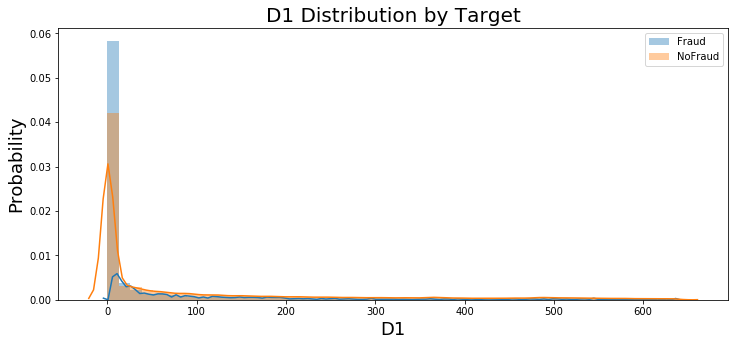

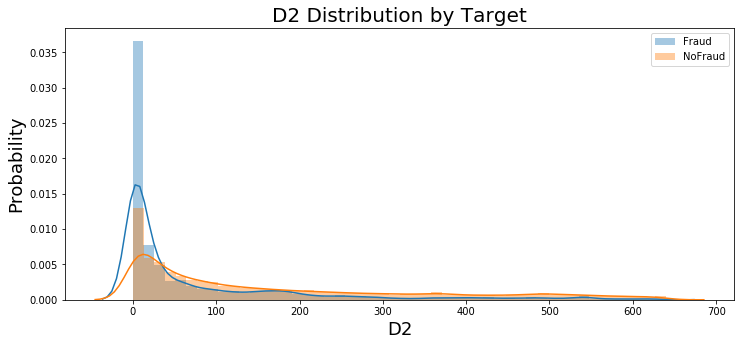

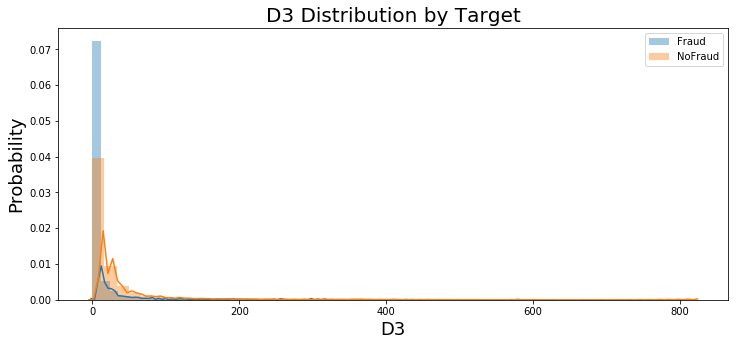

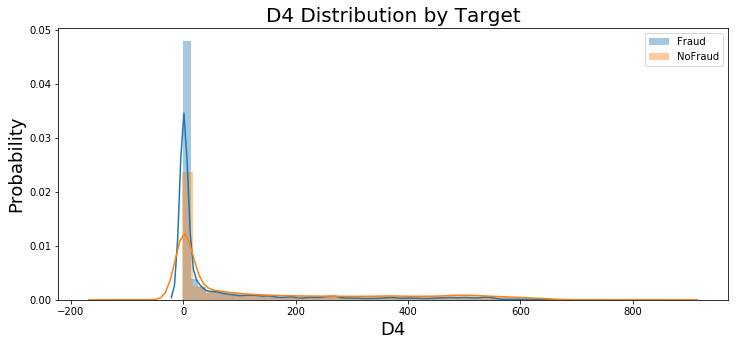

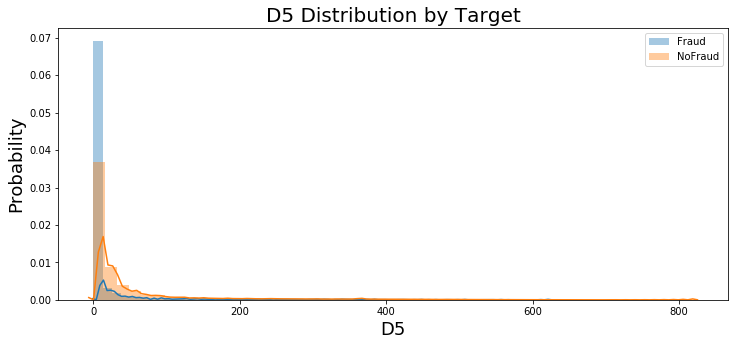

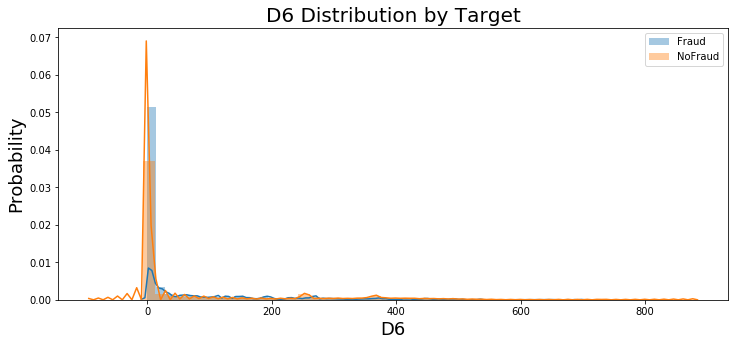

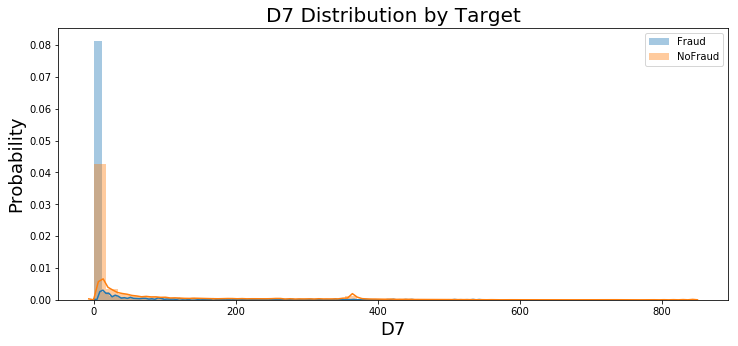

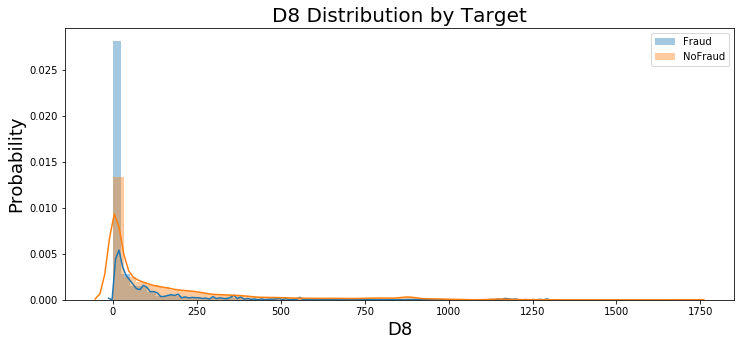

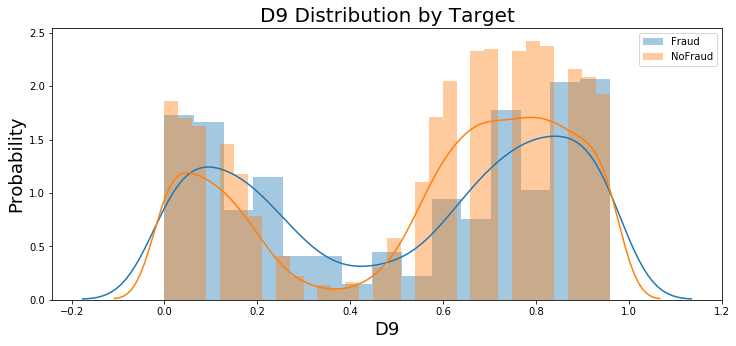

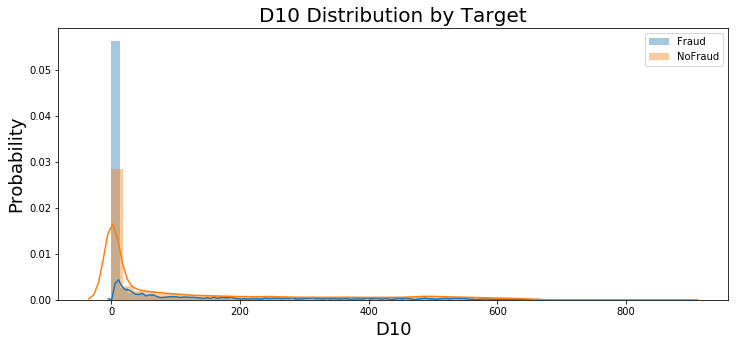

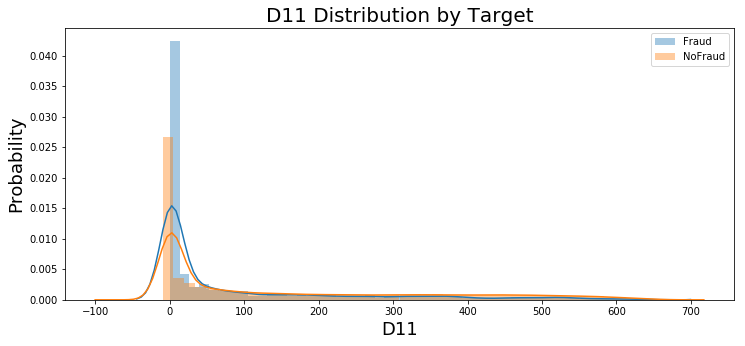

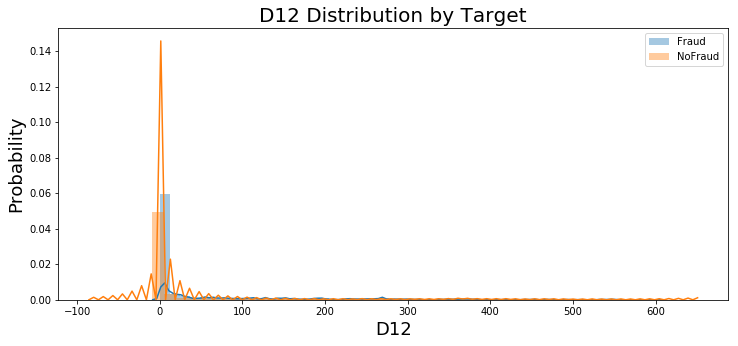

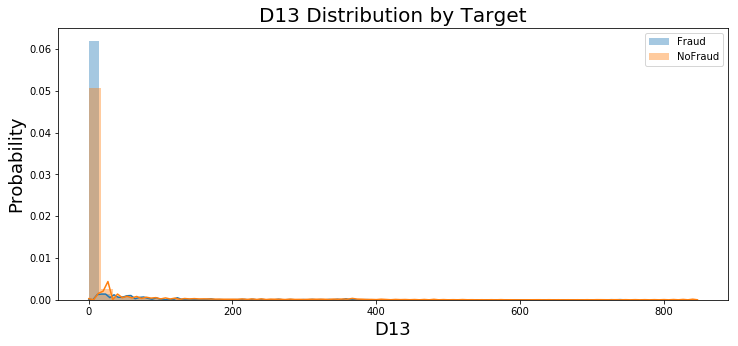

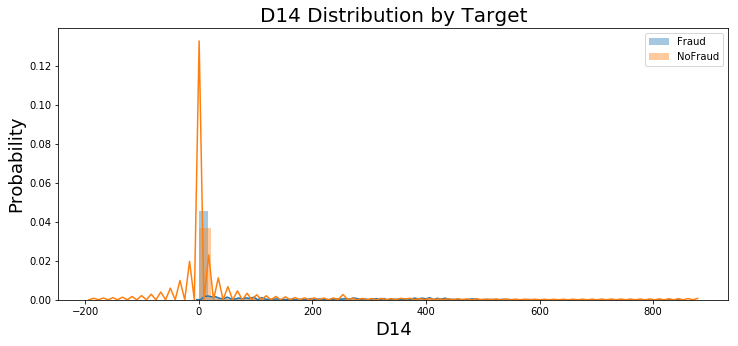

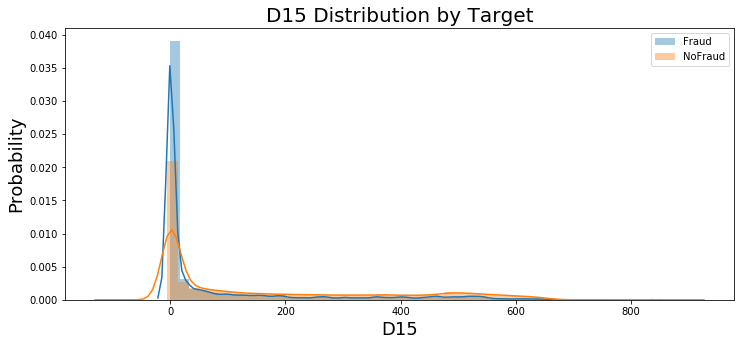

In [244]:
for i in range(0,15):
    col = 'D%s'%(i+1)
    print(df_train_transac.groupby(['isFraud'])[col].agg('describe'))
    compare_distribution(df_train_transac,col,'isFraud',dict)

In [268]:
df_train_transac.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
X, y =df_train_transac.iloc[:,2:], df_train_transac['isFraud']
X = X[X.select_dtypes(exclude=['object']).columns].fillna(0)

In [286]:
X.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [290]:
X_new = SelectKBest(mutual_info_classif, k=100).fit_transform(X, y)
X_new.shape

(590540, 100)

In [293]:
X_new[1,]

array([2.900e+01, 2.755e+03, 4.040e+02, 1.500e+02, 1.020e+02, 8.700e+01,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 